# Figure 1: Best test accuracy by architecture

Builds grouped bar plots for MNIST and CIFAR-10 using summary/history CSVs in `results/`. ViT (baseline) shows a single bar; other architectures show Worst/Avg/Best across all kernel/m combinations.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

arch_order = [
    ("all_standard", "ViT"),
    ("all_performer", "All Performer"),
    ("performer_first", "Performer First"),
    ("standard_first", "Standard First"),
    ("intertwined", "Intertwined"),
]

colors = {
    "ViT": "#4c72b0",
    "Worst": "#c44e52",
    "Avg": "#55a868",
    "Best": "#8172b3",
}

def load_dataset_summary(dataset: str) -> pd.DataFrame:
    rows = []
    for summary_path in results_dir.glob(f"{dataset}/*summary*.csv"):
        row = pd.read_csv(summary_path).iloc[0]
        rows.append({
            "architecture": row.get("architecture"),
            "best_test_acc": pd.to_numeric(row.get("best_test_acc"), errors="coerce"),
        })
    return pd.DataFrame(rows)

def plot_dataset(dataset: str):
    df = load_dataset_summary(dataset)
    if df.empty:
        raise ValueError(f"No summary CSVs found for {dataset} in {results_dir}")

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.18
    ymax = -np.inf
    ymin = np.inf

    legend_drawn = {"Worst": False, "Avg": False, "Best": False, "ViT": False}
    xticks, xticklabels = [], []

    for idx, (arch, label) in enumerate(arch_order):
        subset = df[df["architecture"] == arch]["best_test_acc"].dropna()
        if subset.empty:
            continue

        xticks.append(idx)
        xticklabels.append(label)

        if arch == "all_standard":
            val = subset.iloc[0]
            ymax = max(ymax, val)
            ymin = min(ymin, val)
            ax.bar(
                idx,
                val,
                width * 1.2,
                color=colors["ViT"],
                label="ViT" if not legend_drawn["ViT"] else None,
            )
            legend_drawn["ViT"] = True
            continue

        stats = {
            "Worst": subset.min(),
            "Avg": subset.mean(),
            "Best": subset.max(),
        }
        if not np.isnan(stats["Best"]):
            ymax = max(ymax, stats["Best"])
        if not np.isnan(stats["Worst"]):
            ymin = min(ymin, stats["Worst"])

        for j, key in enumerate(["Worst", "Avg", "Best"]):
            val = stats[key]
            offset = (j - 1) * width
            ax.bar(
                idx + offset,
                val,
                width,
                color=colors[key],
                label=key if not legend_drawn[key] else None,
            )
            legend_drawn[key] = True

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=10)
    ax.set_ylabel("Best test accuracy (%)")
    ax.set_title(f"{dataset} architectures")

    if np.isfinite(ymax) and np.isfinite(ymin):
        span = ymax - ymin
        margin = 0.05 * span if span > 0 else max(0.1, 0.01 * ymax)
        lower = max(0.0, ymin - margin)
        upper = ymax + margin
        ax.set_ylim(lower, upper)

    ax.legend(title="Statistic")
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.show()


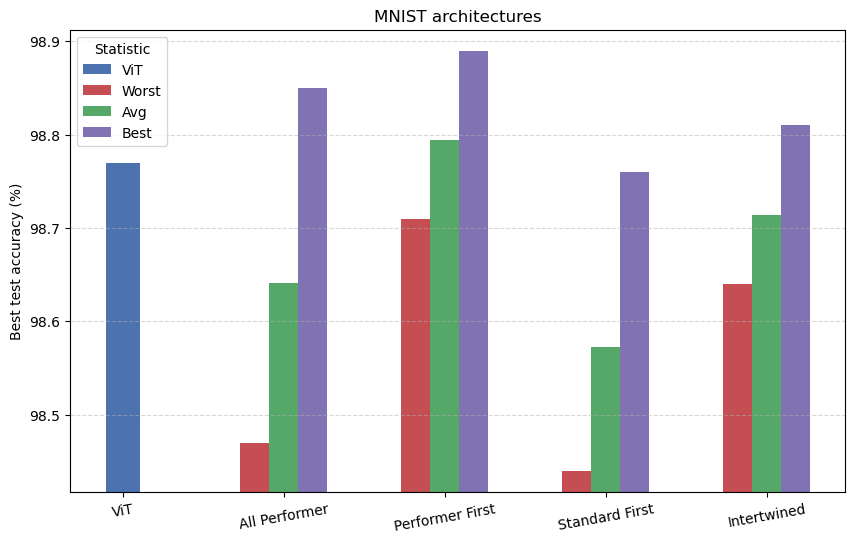

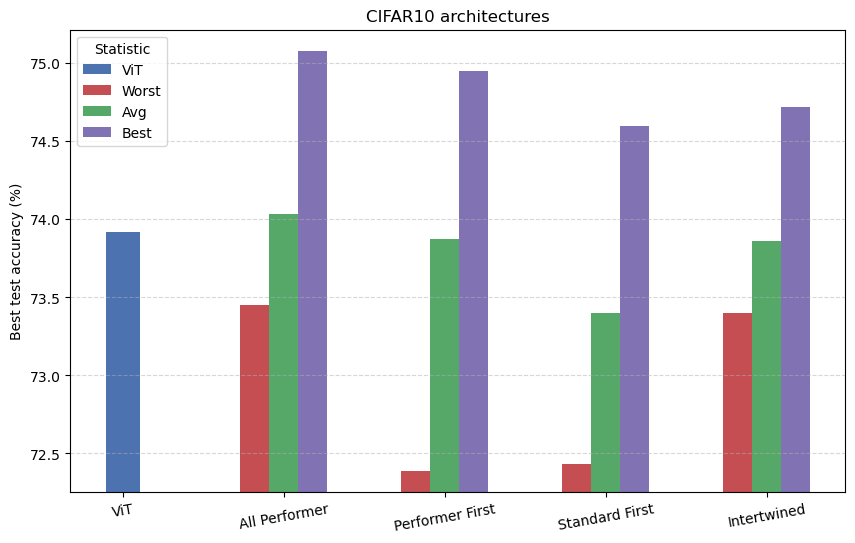

In [2]:
for ds in ["MNIST", "CIFAR10"]:
    plot_dataset(ds)